## MICCAI SCM Baseline

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-01-25 18:45:47.786017: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-25 18:45:49.128603: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-25 18:45:51.076086: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from models import *
from data import * 
from env import *
from harmonize import *
from sim import *

In [4]:
# overall imports
import importlib
import data

from sim.sim import Simulation
from sim.sim_utils import bytes2human, print_system_usage

# data load
import data.data_utils
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome

# data utils
from data.data_utils import (
    reconstruct_connectome,
    reconstruct_upper_triangle,
    make_symmetric,
    expand_X_symmetric,
    expand_Y_symmetric,
    expand_X_symmetric_shared,
    expand_shared_matrices,
    process_cv_splits,  
    expanded_inner_folds_combined_plus_indices
)

import models
import models.metrics
from models.metrics import *

In [5]:
print_system_usage()
total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 63.5%
RAM Usage: 18.0%
Available RAM: 309.3G
Total RAM: 377.1G
52.4G


## Specify connectome and transcriptome

Full brain HCP Enigma

In [6]:
HCP_enigma_structural_count, HCP_enigma_labels, HCP_enigma_lh_indices, HCP_enigma_rh_indices = load_connectome(measure='SC', omit_subcortical=False, include_labels=True, diag=0)
HCP_enigma_functional_conn = load_connectome(measure='FC', omit_subcortical=False)
HCP_coords = load_coords(parcellation='S100', omit_subcortical=False)
HCP_coords_left = load_coords(parcellation='S100', omit_subcortical=False, hemisphere='left')
HCP_coords_right = load_coords(parcellation='S100', omit_subcortical=False, hemisphere='right')
AHBAS100_transcriptome = load_transcriptome(parcellation='S100', omit_subcortical=False)
AHBAS100_transcriptome_PCA = load_transcriptome(parcellation='S100', omit_subcortical=False, run_PCA=True)

Number of components for 95% variance PCA: 34


Full brain HCP1200 and UKBB

In [7]:
HCP1200_structural_count, HCP1200_labels, HCP1200_lh_indices, HCP1200_rh_indices = load_connectome(measure='SC', parcellation='S400', omit_subcortical=False, include_labels=True, diag=1)
HCP1200_functional_conn = load_connectome(measure='FC', parcellation='S400', omit_subcortical=False)
HCP1200_coords = load_coords(parcellation='S400', omit_subcortical=False)
AHBAS400_transcriptome = load_transcriptome(parcellation='S400', omit_subcortical=False)
AHBAS400_transcriptome_PCA = load_transcriptome(parcellation='S400', omit_subcortical=False, run_PCA=True)

Number of components for 95% variance PCA: 105


Assign features and targets

In [8]:
X = AHBAS100_transcriptome_PCA
Y_sc = HCP_enigma_structural_count
Y_fc = HCP_enigma_functional_conn
Y = Y_fc


# X = AHBAS400_transcriptome_PCA
# Y_sc = HCP1200_structural_count
# Y_fc = HCP1200_functional_conn
# Y = Y_fc

left_coords = HCP_coords_left
right_coords = HCP_coords_right

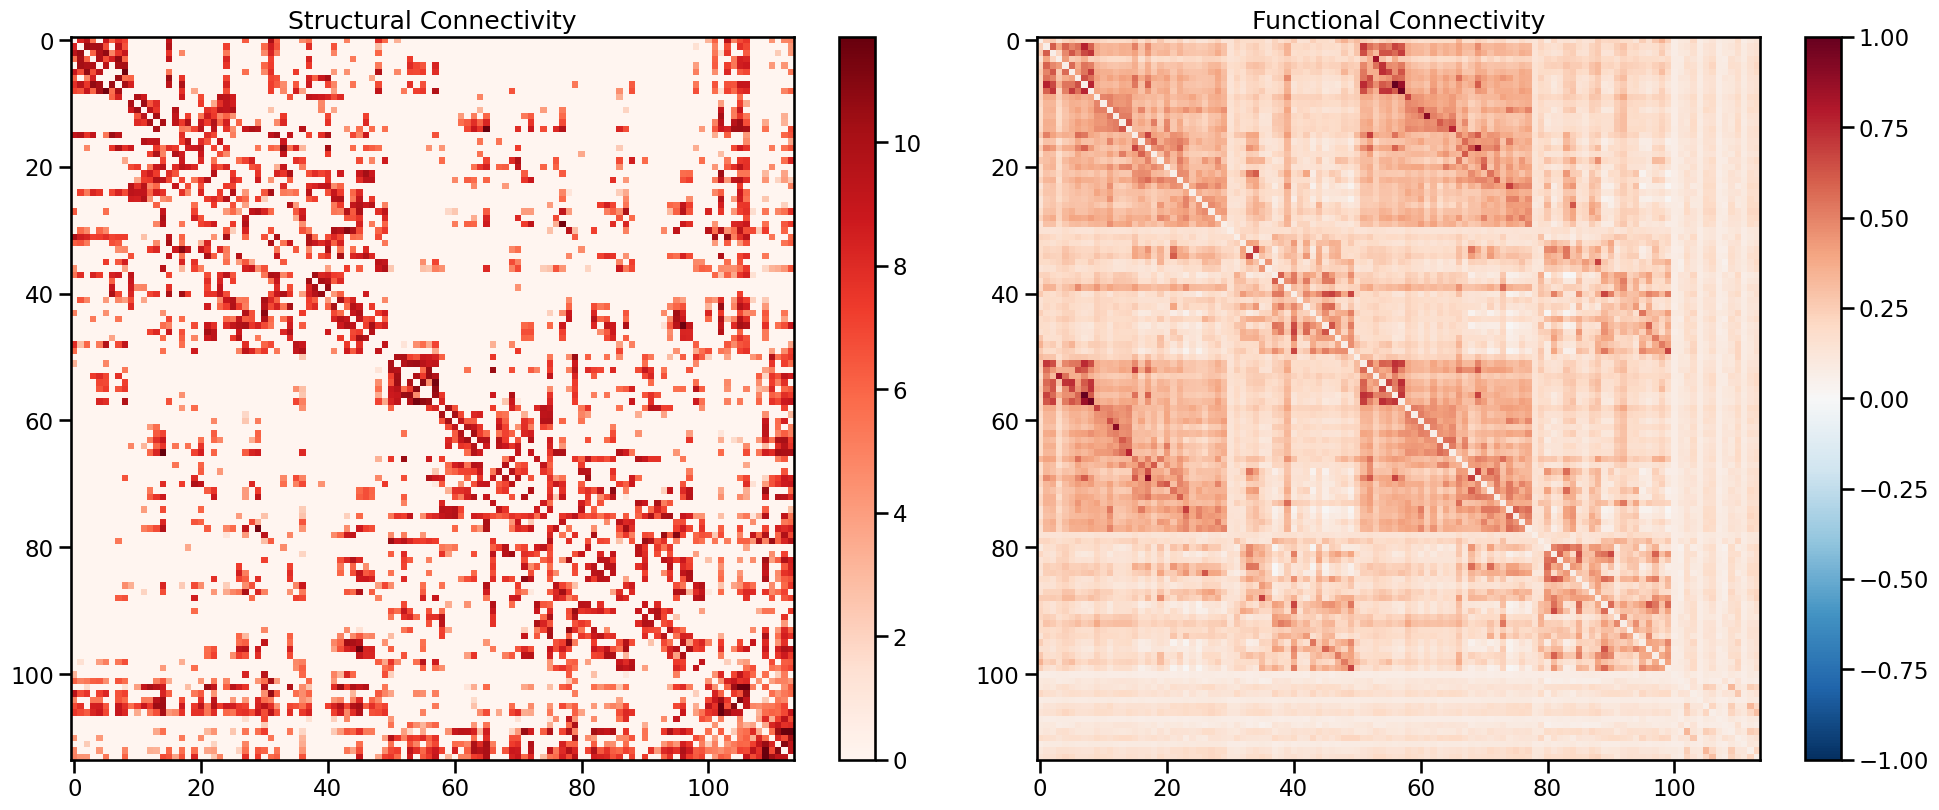

In [9]:
# Visualize structural and functional connectivity matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

im1 = ax1.imshow(Y_sc, cmap='Reds')
ax1.set_title('Structural Connectivity')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(Y_fc, cmap='RdBu_r', vmin=-1, vmax=1)
ax2.set_title('Functional Connectivity') 
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()


## Fit SCM model

In [10]:
# Adapted from https://github.com/kpisti/SCM/tree/v1.0. Below implementation is aligned with CM model from full paper. 
def fit_scm(X, Y, alpha=0.25):
    """
    Fit Structural Covariance Model (SCM) to predict connectivity from gene expression.
    
    Args:
        X: Gene expression PCA matrix (regions x gene_PCA_dim)
        Y: Connectivity matrix (regions x regions) 
        alpha: Regularization parameter for ridge regression
        
    Returns:
        O: Estimated rule matrix (gene_PCA_dim x gene_PCA_dim)
        Y_pred: Predicted connectivity matrix (regions x regions)
        objective: Objective function value
    """
    # Compute Kronecker product of X with itself to obtain K matrix
    K = np.kron(X, X)
    
    # Flatten connectivity matrix Y
    Y_flat = Y.flatten()
    
    # Compute K transpose multiplied by K
    K_transpose_K = np.dot(K.T, K)
    
    # Add regularization term
    K_reg = K_transpose_K + alpha * np.identity(K_transpose_K.shape[0])
    
    # Compute the pseudo-inverse solution
    K_pseudo_inv = np.linalg.inv(K_reg).dot(K.T)
    
    # Estimate the rule matrix in vectorized form
    O_flat = K_pseudo_inv.dot(Y_flat)
    
    # Compute residuals and objective
    residuals = Y_flat - np.dot(K, O_flat)
    residual_norm = np.linalg.norm(residuals)
    
    K_proj = np.dot(K, K_pseudo_inv)
    tau = np.trace(np.identity(K_proj.shape[0]) - K_proj)
    
    objective = (residual_norm ** 2) / (tau ** 2)
    
    # Reshape O to original dimensions
    O = O_flat.reshape(X.shape[1], X.shape[1])
    
    # Predict connectivity matrix
    Y_pred = np.dot(X, np.dot(O, X.T))
    
    # Min-max scale Y_pred to [-1,1] range
    return O, Y_pred, objective

# Fit the model
O, Y_pred, objective = fit_scm(X, Y, alpha=0.25)

# Flatten matrices for calculations
y_true = Y.flatten()
y_pred = Y_pred.flatten()

# Calculate Pearson correlation
pearson_r, _ = stats.pearsonr(y_true, y_pred)

# Calculate R-squared
r2 = r2_score(y_true, y_pred)

# Calculate MSE
mse = mean_squared_error(y_true, y_pred)

print(f"Pearson r: {pearson_r:.3f}")
print(f"R-squared: {r2:.3f}") 
print(f"MSE: {mse:.3f}")


Pearson r: 0.421
R-squared: -3.334
MSE: 0.064


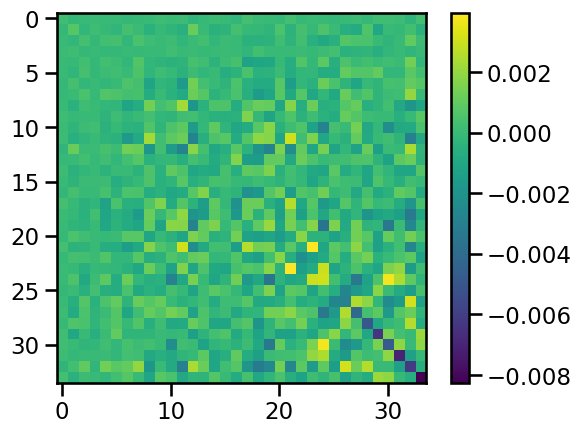

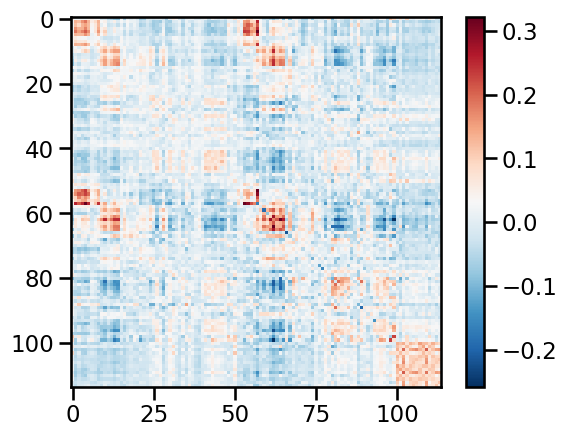

In [11]:
plt.imshow(O)
plt.colorbar()
plt.show()

im = plt.imshow(Y_pred, cmap='RdBu_r')
plt.colorbar(im)
plt.show()

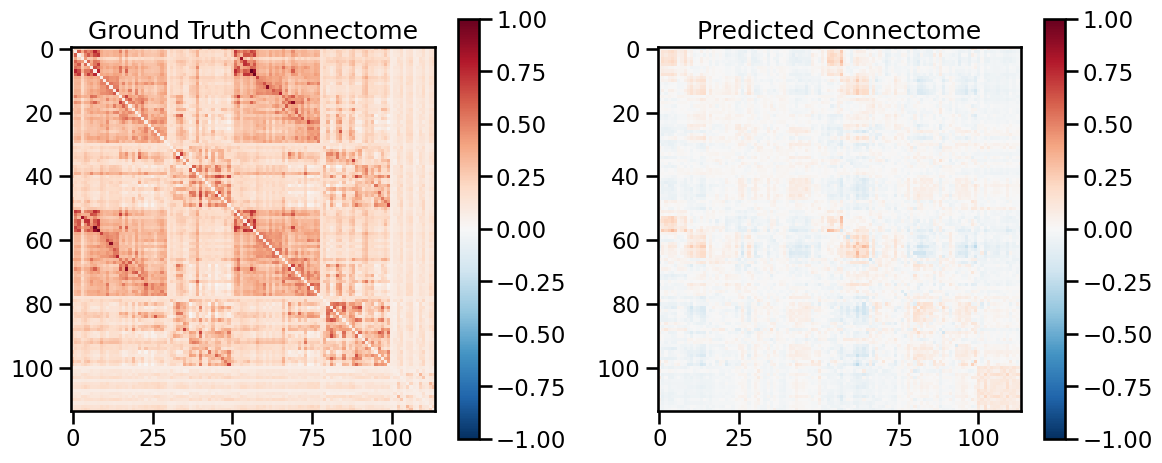

In [12]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ground truth connectome
im1 = ax1.imshow(Y, cmap='RdBu_r', vmin=-1, vmax=1)
ax1.set_title('Ground Truth Connectome')
plt.colorbar(im1, ax=ax1)

# Plot predicted connectome  
im2 = ax2.imshow(Y_pred, cmap='RdBu_r', vmin=-1, vmax=1)
ax2.set_title('Predicted Connectome')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()


permutation 100 of 100


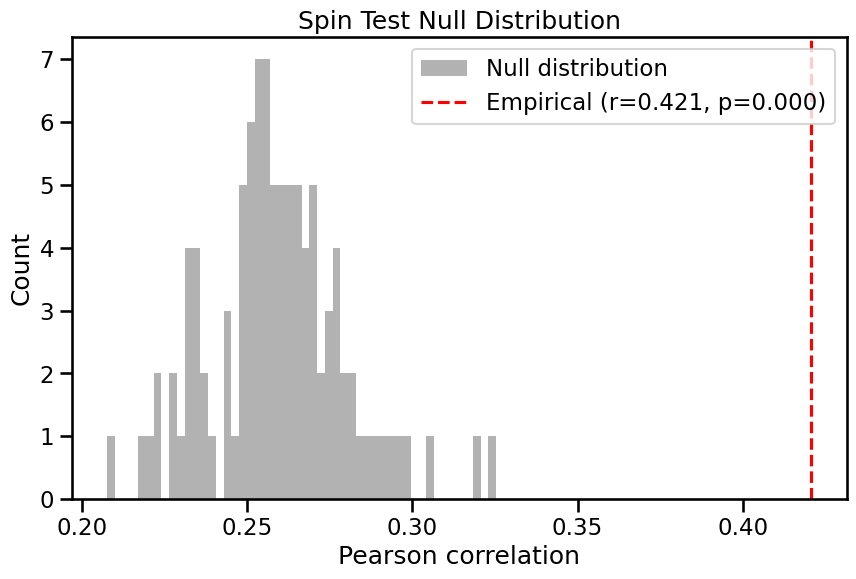

In [14]:
# Number of permutations for null distribution
n_perms = 100

# Calculate empirical correlation
empirical_corr = pearson_r

# Generate all rotations beforehand
rotated_ids = rotate_parcellation(left_coords, right_coords, nrot=n_perms)  # shape = (m, nrot)
rotated_ids = rotated_ids.astype(int)

# Initialize array to store null correlations
null_corrs = np.zeros(n_perms)

# Generate null distribution
for i in range(n_perms):
    # Get rotated indices for this permutation
    perm_ids = rotated_ids[:, i]
    
    # Create rotated Y matrix
    Y_rotated = Y[perm_ids][:, perm_ids]
    
    # Fit SCM on rotated data
    O_null, Y_pred_null, objective_null = fit_scm(X, Y_rotated)
    
    # Flatten for correlation calculation
    y_true_null = Y_rotated.flatten()
    y_pred_null = Y_pred_null.flatten()
    
    # Calculate correlation
    null_corrs[i] = stats.pearsonr(y_true_null, y_pred_null)[0]

# Calculate p-value
p_value = np.mean(null_corrs >= empirical_corr)

# Plot null distribution
plt.figure(figsize=(10, 6))
plt.hist(null_corrs, bins=50, alpha=0.6, color='gray', label='Null distribution')
plt.axvline(empirical_corr, color='red', linestyle='--', 
            label=f'Empirical (r={empirical_corr:.3f}, p={p_value:.3f})')
plt.xlabel('Pearson correlation')
plt.ylabel('Count')
plt.title('Spin Test Null Distribution')
plt.legend()
plt.show()


### Pytorch SCM model

In [43]:
from models.bilinear import BilinearSCM  # using gradient based optimization

X_expanded = expand_X_symmetric(X) # PCA version
Y_expanded = expand_Y_symmetric(Y)

scm_torch_model = BilinearSCM(input_dim=X_expanded.shape[1], learning_rate=0.001, epochs=100, 
                 batch_size=525, regularization='l2', lambda_reg=0.25, bias=True)

scm_torch_model.fit(X_expanded, Y_expanded)
Y_pred = scm_torch_model.predict(X_expanded)


Number of learnable parameters in bilinear SCM layer: 1157
Epoch 10/100, Train Loss: 8.1939
Epoch 20/100, Train Loss: 0.9672
Epoch 30/100, Train Loss: 0.1808
Epoch 40/100, Train Loss: 0.0635
Epoch 50/100, Train Loss: 0.0544
Epoch 60/100, Train Loss: 0.0542
Epoch 70/100, Train Loss: 0.0543
Epoch 80/100, Train Loss: 0.0544
Epoch 90/100, Train Loss: 0.0545
Epoch 100/100, Train Loss: 0.0545


Bilinear layer weights shape: (1, 34, 34)

Bilinear weights:
[[[ 2.32140243e-04 -1.74014611e-04  5.31357327e-05 ...  6.37405101e-05
   -1.94634049e-04  2.82669032e-04]
  [-8.45747563e-05  8.76178092e-04 -2.40646332e-04 ... -1.29810607e-04
    5.25494688e-04 -3.20401829e-04]
  [ 1.83325665e-05 -1.78702467e-04  4.38403920e-04 ... -8.27777840e-05
    7.23434030e-04  2.74241647e-05]
  ...
  [ 1.32465721e-04 -2.84312700e-04 -4.31345034e-05 ... -3.99109180e-04
    1.05188774e-04  2.17875378e-04]
  [-2.01527728e-04  3.20927735e-04  7.39297946e-04 ... -9.40954051e-05
   -3.38705227e-04  3.49883812e-05]
  [ 3.05225927e-04 -4.52323467e-04 -2.29807611e-05 ... -9.64289211e-05
    5.48737808e-06 -3.01171094e-04]]]

Bilinear bias:
[0.10667156]


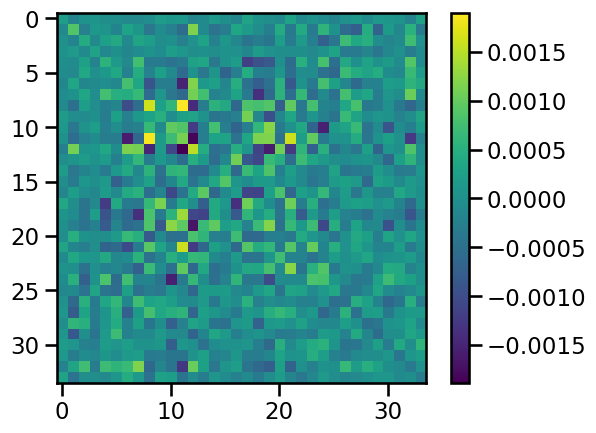

In [47]:
# Get bilinear layer weights
bilinear_weights = scm_torch_model.bilinear.weight.detach().cpu().numpy()
bilinear_bias = scm_torch_model.bilinear.bias.detach().cpu().numpy()

print("Bilinear layer weights shape:", bilinear_weights.shape)
print("\nBilinear weights:")
print(bilinear_weights)
print("\nBilinear bias:")
print(bilinear_bias)

plt.imshow(bilinear_weights.reshape(34, 34))
plt.colorbar()
plt.show()


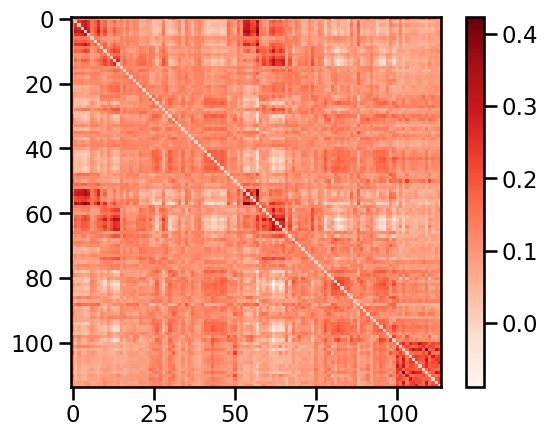

In [48]:
im = plt.imshow(reconstruct_connectome(Y_pred), cmap='Reds')
plt.colorbar(im)
plt.show()

Pearson correlation: 0.425
MSE: 0.027
R2 score: -0.853


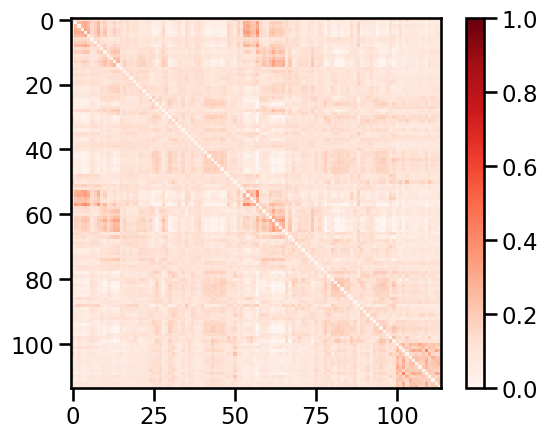

In [49]:
# Calculate metrics
pearson = stats.pearsonr(Y_expanded, Y_pred)[0]
mse = np.mean((Y_expanded - Y_pred)**2)
r2 = r2_score(Y_expanded, Y_pred)

print(f"Pearson correlation: {pearson:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R2 score: {r2:.3f}")

im = plt.imshow(reconstruct_connectome(Y_pred), cmap='Reds', vmin=0, vmax=1)
plt.colorbar(im)
plt.show()